# Meme Offensive Classification Model

## Project Overview
This notebook implements a **multimodal deep learning model** for meme offensive classification using both **image features** and **OCR text** to accurately classify meme sentiments.

## Objective
Build a high-performance binary classifier that can accurately identify meme sentiment as:
- **Class 1 (Offensive)**: Meme contains offensive content (slight, very offensive, or hateful)
- **Class 0 (Not Offensive)**: Meme contains no offensive content

## Model Architecture
- **Type**: Multimodal Deep Learning Model
- **Image Branch**: ResNet-based CNN for visual feature extraction
- **Text Branch**: LSTM/Bidirectional LSTM for text sequence processing
- **Fusion Strategy**: Concatenation + Dense layers for combined prediction
- **Key Features**:
  - Residual connections for improved gradient flow
  - Global Average Pooling for computational efficiency
  - Bidirectional LSTM for contextual text understanding
  - Text embeddings for semantic representation
  - Dropout and regularization to prevent overfitting
  - Sigmoid activation for binary classification

## Advanced Dataset Features
- **Multiple Dataset Support**: Combines dataset_1 (Excel) and dataset_2 (CSV)
- **Intelligent Column Mapping**: Handles different column names automatically
- **Offensive Normalization**: Maps 4-class to binary (not_offensive → Not Offensive, slight/very_offensive/hateful_offensive → Offensive)
- **Image Validation**: Validates each image file before training
- **Auto-Filtering**: Filters out corrupted, invalid, or missing images
- **Automatic Balancing**: Ensures equal samples per class to prevent bias
- **Smart Sampling**: Randomly selects from larger class to match smaller class
- **Text Preprocessing**: Cleans and tokenizes OCR text for optimal NLP processing
- **Multiple Formats**: Supports .jpg, .jpeg, .png, .bmp, .gif images

## Dataset
- **Source**: `meme_sentiment_dataset/` directory
  - `dataset_1/`: 6,992 samples (Excel format, 4-class offensive)
  - `dataset_2/`: 7,000 samples (CSV format, 4-class offensive)
- **Split**: 70% Training / 15% Validation / 15% Testing
- **Image Size**: 224×224 pixels
- **Classes**: Not Offensive (0), Offensive (1)
- **Features**: Image pixels + OCR text
- **Validation**: All images validated before training (missing files filtered)
- **Balancing**: Automatic class balancing to prevent model bias

## Training Configuration
- **Optimizer**: Adam (learning rate: 0.0001)
- **Batch Size**: 16
- **Epochs**: 25
- **Loss Function**: Binary Crossentropy
- **Callbacks**: Early Stopping, Model Checkpoint, ReduceLROnPlateau

---

In [1]:
# Library imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pathlib
import shutil
import random
from glob import glob
import re
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print(f"[INFO] TensorFlow version: {tf.__version__}")
print(f"[INFO] GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"[INFO] Pandas version: {pd.__version__}")
print(f"[INFO] NumPy version: {np.__version__}")
print(f"[INFO] Libraries imported successfully")

[INFO] TensorFlow version: 2.20.0
[INFO] GPU available: []
[INFO] Pandas version: 2.2.3
[INFO] NumPy version: 1.26.4
[INFO] Libraries imported successfully


## 2. Dataset Configuration
Configure the dataset directories and verify they exist with proper structure.

In [2]:
# Dataset directories configuration
DATASET_BASE_DIR = "../datasets/meme_sentiment_dataset"
DATASET1_DIR = os.path.join(DATASET_BASE_DIR, "dataset_1")
DATASET2_DIR = os.path.join(DATASET_BASE_DIR, "dataset_2")
MODEL_SAVE_DIR = "../models"
RESULTS_DIR = "../results"

# Verify dataset directories exist
if not os.path.exists(DATASET1_DIR):
    raise ValueError(f"[ERROR] Dataset 1 directory not found: {DATASET1_DIR}")
if not os.path.exists(DATASET2_DIR):
    raise ValueError(f"[ERROR] Dataset 2 directory not found: {DATASET2_DIR}")

# Create necessary directories
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Dataset file paths
DATASET1_SENTIMENT_FILE = os.path.join(DATASET1_DIR, "sentiments.xlsx")
DATASET2_SENTIMENT_FILE = os.path.join(DATASET2_DIR, "sentiments.csv")
DATASET1_IMAGES_DIR = os.path.join(DATASET1_DIR, "images")
DATASET2_IMAGES_DIR = os.path.join(DATASET2_DIR, "images")

print(f"[INFO] Dataset directories configured successfully")
print(f"       >> Dataset 1: {DATASET1_DIR}")
print(f"       >> Dataset 2: {DATASET2_DIR}")
print(f"       >> Model save directory: {MODEL_SAVE_DIR}")
print(f"       >> Results directory: {RESULTS_DIR}")
print(f"       >> Dataset 1 images: {DATASET1_IMAGES_DIR}")
print(f"       >> Dataset 2 images: {DATASET2_IMAGES_DIR}")

[INFO] Dataset directories configured successfully
       >> Dataset 1: ../datasets/meme_sentiment_dataset\dataset_1
       >> Dataset 2: ../datasets/meme_sentiment_dataset\dataset_2
       >> Model save directory: ../models
       >> Results directory: ../results
       >> Dataset 1 images: ../datasets/meme_sentiment_dataset\dataset_1\images
       >> Dataset 2 images: ../datasets/meme_sentiment_dataset\dataset_2\images


## 3. Load and Combine Datasets
Load both datasets, handle different column naming conventions, and combine them into a unified dataset.

In [3]:
# Function to normalize sentiment labels to binary classes
def normalize_offensive(sentiment):
    """
    Normalize offensive labels from both datasets to binary classes:
    - Not Offensive (0): not_offensive
    - Offensive (1): slight, very_offensive, hateful_offensive
    
    Args:
        sentiment (str): Original sentiment label
    
    Returns:
        int: Normalized sentiment class (0 or 1)
    """
    sentiment = str(sentiment).lower().strip()
    
    if sentiment in ['not_offensive']:
        return 0  # Not Offensive
    elif sentiment in ['slight', 'very_offensive', 'hateful_offensive']:
        return 1  # Offensive
    else:
        return None  # Invalid offensive label

print("[INFO] Sentiment normalization function defined")
print("       >> Mapping: [not_offensive] → Class 0 (Not Offensive)")
print("       >> Mapping: [slight, very_offensive, hateful_offensive] → Class 1 (Offensive)")

[INFO] Sentiment normalization function defined
       >> Mapping: [not_offensive] → Class 0 (Not Offensive)
       >> Mapping: [slight, very_offensive, hateful_offensive] → Class 1 (Offensive)


In [4]:
# Load Dataset 1 (Excel format)
print("[INFO] Loading Dataset 1 (Excel)...")
print("=" * 80)

df1 = pd.read_excel(DATASET1_SENTIMENT_FILE)

print(f"[INFO] Dataset 1 loaded successfully")
print(f"       >> Shape: {df1.shape}")
print(f"       >> Columns: {list(df1.columns)}")

# Standardize column names for Dataset 1
df1_standardized = pd.DataFrame({
    'image_filename': df1['image_name'],
    'ocr_text': df1['text_corrected'].fillna(df1['text_ocr']),  # Use corrected text, fallback to OCR
    'offensive_raw': df1['offensive'],
    'dataset_source': 'dataset_1'
})

# Add image paths
df1_standardized['image_path'] = df1_standardized['image_filename'].apply(
    lambda x: os.path.join(DATASET1_IMAGES_DIR, x)
)

print(f"[INFO] Dataset 1 standardized")
print(f"       >> Standardized columns: {list(df1_standardized.columns)}")
print(f"       >> Offensive value counts:")
print(df1['offensive'].value_counts())
print("=" * 80)

[INFO] Loading Dataset 1 (Excel)...
[INFO] Dataset 1 loaded successfully
       >> Shape: (6992, 9)
       >> Columns: ['Unnamed: 0', 'image_name', 'text_ocr', 'text_corrected', 'humour', 'sarcasm', 'offensive', 'motivational', 'overall_sentiment']
[INFO] Dataset 1 standardized
       >> Standardized columns: ['image_filename', 'ocr_text', 'offensive_raw', 'dataset_source', 'image_path']
       >> Offensive value counts:
offensive
not_offensive        2713
slight               2592
very_offensive       1466
hateful_offensive     221
Name: count, dtype: int64
[INFO] Dataset 1 loaded successfully
       >> Shape: (6992, 9)
       >> Columns: ['Unnamed: 0', 'image_name', 'text_ocr', 'text_corrected', 'humour', 'sarcasm', 'offensive', 'motivational', 'overall_sentiment']
[INFO] Dataset 1 standardized
       >> Standardized columns: ['image_filename', 'ocr_text', 'offensive_raw', 'dataset_source', 'image_path']
       >> Offensive value counts:
offensive
not_offensive        2713
slight    

In [5]:
# Load Dataset 2 (CSV format)
print("\n[INFO] Loading Dataset 2 (CSV)...")
print("=" * 80)

df2 = pd.read_csv(DATASET2_SENTIMENT_FILE)

print(f"[INFO] Dataset 2 loaded successfully")
print(f"       >> Shape: {df2.shape}")
print(f"       >> Columns: {list(df2.columns)}")

# Standardize column names for Dataset 2
# Dataset 2 uses URLs instead of filenames, so we'll use ID as filename
df2_standardized = pd.DataFrame({
    'image_filename': df2['Id'].apply(lambda x: f"{x}.jpg"),  # Use ID as filename
    'ocr_text': df2['ocr_text'].fillna(''),
    'offensive_raw': df2['offensive'],
    'dataset_source': 'dataset_2'
})

# Add image paths
df2_standardized['image_path'] = df2_standardized['image_filename'].apply(
    lambda x: os.path.join(DATASET2_IMAGES_DIR, x)
)

print(f"[INFO] Dataset 2 standardized")
print(f"       >> Standardized columns: {list(df2_standardized.columns)}")
print(f"       >> Offensive value counts:")
print(df2['offensive'].value_counts())
print("=" * 80)


[INFO] Loading Dataset 2 (CSV)...
[INFO] Dataset 2 loaded successfully
       >> Shape: (7000, 9)
       >> Columns: ['Id', 'Image url', 'ocr_text', 'humour', 'sarcastic', 'offensive', 'motivational', 'overall_sentiment', 'classification_based_on']
[INFO] Dataset 2 standardized
       >> Standardized columns: ['image_filename', 'ocr_text', 'offensive_raw', 'dataset_source', 'image_path']
       >> Offensive value counts:
offensive
not_offensive        5182
slight               1107
very_offensive        529
hateful_offensive     182
Name: count, dtype: int64


In [6]:
# Combine both datasets
print("\n[INFO] Combining datasets...")
print("=" * 80)

combined_df = pd.concat([df1_standardized, df2_standardized], ignore_index=True)

print(f"[INFO] Datasets combined successfully")
print(f"       >> Total samples: {len(combined_df)}")
print(f"       >> Dataset 1 samples: {len(df1_standardized)}")
print(f"       >> Dataset 2 samples: {len(df2_standardized)}")
print(f"       >> Combined columns: {list(combined_df.columns)}")

# Normalize sentiments to binary classes
combined_df['offensive_label'] = combined_df['offensive_raw'].apply(normalize_offensive)

# Remove rows with invalid sentiments
before_filter = len(combined_df)
combined_df = combined_df.dropna(subset=['offensive_label'])
after_filter = len(combined_df)

if before_filter != after_filter:
    print(f"       >> Removed {before_filter - after_filter} samples with invalid sentiment labels")

# Convert sentiment to integer
combined_df['offensive_label'] = combined_df['offensive_label'].astype(int)

print(f"\n[INFO] Offensive distribution after normalization:")
print(combined_df['offensive_label'].value_counts().sort_index())
print(f"       >> Class 0 (Not Offensive): {(combined_df['offensive_label'] == 0).sum()} samples")
print(f"       >> Class 1 (Offensive): {(combined_df['offensive_label'] == 1).sum()} samples")
print("=" * 80)


[INFO] Combining datasets...
[INFO] Datasets combined successfully
       >> Total samples: 13992
       >> Dataset 1 samples: 6992
       >> Dataset 2 samples: 7000
       >> Combined columns: ['image_filename', 'ocr_text', 'offensive_raw', 'dataset_source', 'image_path']

[INFO] Offensive distribution after normalization:
offensive_label
0    7895
1    6097
Name: count, dtype: int64
       >> Class 0 (Not Offensive): 7895 samples
       >> Class 1 (Offensive): 6097 samples


## 4. Image Validation & Filtering
Validate all images to ensure they exist and can be loaded by TensorFlow. Filter out missing or corrupted images.

In [7]:
# Function to validate if image exists and is valid
def validate_image(image_path):
    """
    Check if an image file exists and is a valid image.
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        bool: True if valid image exists, False otherwise
    """
    try:
        # Check if file exists
        if not os.path.exists(image_path):
            return False
        
        # Try to load the image with PIL
        img = Image.open(image_path)
        img.verify()  # Verify it's a valid image
        
        # Try to read with TensorFlow as well
        img_bytes = tf.io.read_file(image_path)
        img_tensor = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
        
        return True
    except:
        return False

print("[INFO] Image validation function defined")

[INFO] Image validation function defined


In [8]:
# Validate all images
print("\n[INFO] Validating images (this may take a moment)...")
print("=" * 80)

initial_count = len(combined_df)
combined_df['image_valid'] = combined_df['image_path'].apply(validate_image)

# Filter valid images
valid_df = combined_df[combined_df['image_valid'] == True].copy()
invalid_count = initial_count - len(valid_df)

print(f"[INFO] Image validation completed")
print(f"       >> Total samples checked: {initial_count}")
print(f"       >> Valid images: {len(valid_df)}")
print(f"       >> Invalid/Missing images: {invalid_count}")

if invalid_count > 0:
    print(f"       >> Filtered out {invalid_count} samples with invalid/missing images")

# Remove the validation column (no longer needed)
valid_df = valid_df.drop(columns=['image_valid'])

print(f"\n[INFO] Final dataset after validation:")
print(f"       >> Total samples: {len(valid_df)}")
print(f"       >> Offensive distribution:")
print(valid_df['offensive_label'].value_counts().sort_index())
print("=" * 80)


[INFO] Validating images (this may take a moment)...
[INFO] Image validation completed
       >> Total samples checked: 13992
       >> Valid images: 13991
       >> Invalid/Missing images: 1
       >> Filtered out 1 samples with invalid/missing images

[INFO] Final dataset after validation:
       >> Total samples: 13991
       >> Offensive distribution:
offensive_label
0    7895
1    6096
Name: count, dtype: int64


## 5. Dataset Balancing
Balance the dataset to ensure equal samples per class to prevent model bias.

In [9]:
# Balance the dataset by class
print("\n[INFO] Balancing dataset across sentiment classes...")
print("=" * 80)

# Get current class distribution
class_counts = valid_df['offensive_label'].value_counts().sort_index()
print(f"[INFO] Current class distribution:")
for label, count in class_counts.items():
    offensive_name = ['Not Offensive', 'Offensive'][label]
    print(f"       >> Class {label} ({offensive_name}): {count} samples")

# Find minimum class size
min_class_size = class_counts.min()
print(f"\n[INFO] Minimum class size: {min_class_size}")
print(f"       >> Balancing all classes to {min_class_size} samples each")

# Sample each class to match minimum size
balanced_dfs = []
for label in [0, 1]:
    class_df = valid_df[valid_df['offensive_label'] == label]
    
    if len(class_df) > min_class_size:
        # Randomly sample to match minimum
        class_df_sampled = class_df.sample(n=min_class_size, random_state=42)
        offensive_name = ['Not Offensive', 'Offensive'][label]
        print(f"       >> Class {label} ({offensive_name}): Sampled {min_class_size} from {len(class_df)}")
    else:
        class_df_sampled = class_df
        offensive_name = ['Not Offensive', 'Offensive'][label]
        print(f"       >> Class {label} ({offensive_name}): Using all {len(class_df)} samples")
    
    balanced_dfs.append(class_df_sampled)

# Combine balanced classes
balanced_df = pd.concat(balanced_dfs, ignore_index=True)

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n[INFO] Dataset balanced successfully")
print(f"       >> Total samples: {len(balanced_df)}")
print(f"       >> Samples per class: {min_class_size}")
print(f"       >> Final distribution:")
print(balanced_df['offensive_label'].value_counts().sort_index())
print("=" * 80)


[INFO] Balancing dataset across sentiment classes...
[INFO] Current class distribution:
       >> Class 0 (Not Offensive): 7895 samples
       >> Class 1 (Offensive): 6096 samples

[INFO] Minimum class size: 6096
       >> Balancing all classes to 6096 samples each
       >> Class 0 (Not Offensive): Sampled 6096 from 7895
       >> Class 1 (Offensive): Using all 6096 samples

[INFO] Dataset balanced successfully
       >> Total samples: 12192
       >> Samples per class: 6096
       >> Final distribution:
offensive_label
0    6096
1    6096
Name: count, dtype: int64


## 6. Text Preprocessing
Clean and prepare OCR text for the NLP branch of the model.

In [10]:
# Text cleaning function
def clean_text(text):
    """
    Clean and preprocess OCR text for NLP processing.
    
    Args:
        text (str): Raw OCR text
    
    Returns:
        str: Cleaned text
    """
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("[INFO] Text cleaning function defined")

[INFO] Text cleaning function defined


In [11]:
# Clean all texts
print("\n[INFO] Cleaning OCR texts...")
print("=" * 80)

balanced_df['ocr_text_clean'] = balanced_df['ocr_text'].apply(clean_text)

# Count empty texts
empty_texts = (balanced_df['ocr_text_clean'] == '').sum()
print(f"[INFO] Text cleaning completed")
print(f"       >> Total texts: {len(balanced_df)}")
print(f"       >> Empty texts: {empty_texts}")
print(f"       >> Non-empty texts: {len(balanced_df) - empty_texts}")

# Replace empty texts with a placeholder
balanced_df.loc[balanced_df['ocr_text_clean'] == '', 'ocr_text_clean'] = 'no text available'

print(f"       >> Replaced empty texts with placeholder: 'no text available'")
print("\n[INFO] Sample cleaned texts:")
for i in range(min(3, len(balanced_df))):
    print(f"       >> Sample {i+1}: {balanced_df.iloc[i]['ocr_text_clean'][:80]}...")
print("=" * 80)


[INFO] Cleaning OCR texts...
[INFO] Text cleaning completed
       >> Total texts: 12192
       >> Empty texts: 6
       >> Non-empty texts: 12186
       >> Replaced empty texts with placeholder: 'no text available'

[INFO] Sample cleaned texts:
       >> Sample 1: the two states that legalized.pot are getting together for a "super bowlghetto...
       >> Sample 2: when you arguing wit somebody and you try and be the bigger person and walk away...
       >> Sample 3: mr. bean loves his rides to the vet this time he got to see snow for the first t...


## 7. Text Tokenization and Encoding
Tokenize text data and convert to sequences for the LSTM branch.

In [12]:
# Text tokenization parameters
MAX_WORDS = 10000  # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Maximum sequence length for padding

print("\n[INFO] Tokenizing text data...")
print("=" * 80)

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')

# Fit tokenizer on texts
tokenizer.fit_on_texts(balanced_df['ocr_text_clean'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(balanced_df['ocr_text_clean'])

# Pad sequences to uniform length
text_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"[INFO] Text tokenization completed")
print(f"       >> Vocabulary size: {len(tokenizer.word_index)}")
print(f"       >> Maximum vocabulary: {MAX_WORDS}")
print(f"       >> Sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"       >> Text sequences shape: {text_sequences.shape}")
print(f"       >> Sample sequence: {text_sequences[0][:20]}...")
print("=" * 80)


[INFO] Tokenizing text data...
[INFO] Text tokenization completed
       >> Vocabulary size: 21544
       >> Maximum vocabulary: 10000
       >> Sequence length: 100
       >> Text sequences shape: (12192, 100)
       >> Sample sequence: [   2  227  801   18 8616 3243   23  221  572   16    4  731 8617    0
    0    0    0    0    0    0]...


## 8. Dataset Splitting
Split the dataset into training (70%), validation (15%), and testing (15%) sets.

In [13]:
# Dataset splitting ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print("\n[INFO] Splitting dataset...")
print("=" * 80)

# Get total dataset size
total_size = len(balanced_df)

# Calculate split indices
train_size = int(TRAIN_RATIO * total_size)
val_size = int(VAL_RATIO * total_size)
test_size = total_size - train_size - val_size

# Split indices
train_end = train_size
val_end = train_size + val_size

# Get image paths and labels
image_paths = balanced_df['image_path'].values
labels = balanced_df['offensive_label'].values

# Split data
train_image_paths = image_paths[:train_end]
train_text_sequences = text_sequences[:train_end]
train_labels = labels[:train_end]

val_image_paths = image_paths[train_end:val_end]
val_text_sequences = text_sequences[train_end:val_end]
val_labels = labels[train_end:val_end]

test_image_paths = image_paths[val_end:]
test_text_sequences = text_sequences[val_end:]
test_labels = labels[val_end:]

print(f"[INFO] Dataset split completed")
print(f"       >> Total samples: {total_size}")
print(f"       >> Training samples: {len(train_labels)} ({TRAIN_RATIO:.0%})")
print(f"       >> Validation samples: {len(val_labels)} ({VAL_RATIO:.0%})")
print(f"       >> Testing samples: {len(test_labels)} ({TEST_RATIO:.0%})")

# Check label distribution in each split
print(f"\n[INFO] Label distribution in splits:")
for split_name, split_labels in [('Training', train_labels), ('Validation', val_labels), ('Testing', test_labels)]:
    print(f"       >> {split_name}:")
    for label in [0, 1]:
        count = (split_labels == label).sum()
        percentage = (count / len(split_labels)) * 100
        offensive_name = ['Not Offensive', 'Offensive'][label]
        print(f"          • Class {label} ({offensive_name}): {count} ({percentage:.1f}%)")

print("=" * 80)


[INFO] Splitting dataset...
[INFO] Dataset split completed
       >> Total samples: 12192
       >> Training samples: 8534 (70%)
       >> Validation samples: 1828 (15%)
       >> Testing samples: 1830 (15%)

[INFO] Label distribution in splits:
       >> Training:
          • Class 0 (Not Offensive): 4323 (50.7%)
          • Class 1 (Offensive): 4211 (49.3%)
       >> Validation:
          • Class 0 (Not Offensive): 861 (47.1%)
          • Class 1 (Offensive): 967 (52.9%)
       >> Testing:
          • Class 0 (Not Offensive): 912 (49.8%)
          • Class 1 (Offensive): 918 (50.2%)


## 9. Data Generators for Multimodal Input
Create custom data generators that load images and provide text sequences for training.

In [14]:
# Hyperparameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 16
NUM_CLASSES = 1  # Binary classification

print(f"[INFO] Hyperparameters configured:")
print(f"       >> Image size: {IMG_SIZE}")
print(f"       >> Batch size: {BATCH_SIZE}")
print(f"       >> Classification type: Binary (Offensive vs Not Offensive)")

[INFO] Hyperparameters configured:
       >> Image size: (224, 224)
       >> Batch size: 16
       >> Classification type: Binary (Offensive vs Not Offensive)


In [15]:
# Custom data generator for multimodal input
class MultimodalDataGenerator(keras.utils.Sequence):
    """
    Custom data generator that loads images and provides text sequences.
    Generates batches of ((images, text_sequences), labels) for multimodal training.
    """
    
    def __init__(self, image_paths, text_sequences, labels, batch_size=16, 
                 img_size=(224, 224), augment=False, shuffle=True):
        """
        Initialize the data generator.
        
        Args:
            image_paths (array): Array of image file paths
            text_sequences (array): Array of tokenized text sequences
            labels (array): Array of sentiment labels (0 or 1 for binary)
            batch_size (int): Batch size for training
            img_size (tuple): Target image size (height, width)
            augment (bool): Whether to apply data augmentation
            shuffle (bool): Whether to shuffle data at epoch end
        """
        self.image_paths = image_paths
        self.text_sequences = text_sequences
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths))
        
        # Data augmentation layers
        if self.augment:
            self.augmentation = keras.Sequential([
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.0417),  # ±15 degrees
                layers.RandomContrast(0.2),
                layers.RandomZoom(0.15),
                layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
            ])
        
        self.on_epoch_end()
    
    def __len__(self):
        """Return number of batches per epoch."""
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data."""
        # Get batch indices
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_idx:end_idx]
        
        # Generate batch data
        batch_images = np.zeros((len(batch_indices), self.img_size[0], self.img_size[1], 3))
        batch_texts = np.zeros((len(batch_indices), self.text_sequences.shape[1]))
        batch_labels = np.zeros((len(batch_indices), 1))  # Binary labels
        
        for i, idx in enumerate(batch_indices):
            # Load and preprocess image
            img_path = self.image_paths[idx]
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # Normalize to [0, 1]
            
            # Apply augmentation if enabled
            if self.augment:
                img_array = self.augmentation(np.expand_dims(img_array, 0), training=True)[0]
            
            batch_images[i] = img_array
            batch_texts[i] = self.text_sequences[idx]
            
            # Binary labels (0 or 1)
            batch_labels[i, 0] = self.labels[idx]
        
        return (batch_images, batch_texts), batch_labels
    
    def on_epoch_end(self):
        """Shuffle indices after each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)

print("[INFO] Multimodal data generator class defined for binary classification")

[INFO] Multimodal data generator class defined for binary classification


In [16]:
# Create data generators
print("\n[INFO] Creating data generators...")
print("=" * 80)

train_generator = MultimodalDataGenerator(
    train_image_paths, 
    train_text_sequences, 
    train_labels,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    augment=True,  # Apply augmentation to training data
    shuffle=True
)

val_generator = MultimodalDataGenerator(
    val_image_paths, 
    val_text_sequences, 
    val_labels,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    augment=False,  # No augmentation for validation
    shuffle=False
)

test_generator = MultimodalDataGenerator(
    test_image_paths, 
    test_text_sequences, 
    test_labels,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    augment=False,  # No augmentation for testing
    shuffle=False
)

print(f"[INFO] Data generators created successfully")
print(f"       >> Training generator: {len(train_generator)} batches")
print(f"       >> Validation generator: {len(val_generator)} batches")
print(f"       >> Test generator: {len(test_generator)} batches")
print(f"       >> Training augmentation: Enabled")
print(f"       >> Validation/Test augmentation: Disabled")
print("=" * 80)


[INFO] Creating data generators...
[INFO] Data generators created successfully
       >> Training generator: 534 batches
       >> Validation generator: 115 batches
       >> Test generator: 115 batches
       >> Training augmentation: Enabled
       >> Validation/Test augmentation: Disabled


## 10. Multimodal Model Architecture
Build a multimodal deep learning model with separate branches for image and text processing, then fuse them for binary sentiment classification.

In [17]:
# Residual Block for Image Branch
def residual_block(x, filters, kernel_size=3, stride=1, name=None):
    """
    Creates a residual block with skip connection for the image processing branch.
    
    Args:
        x: Input tensor
        filters: Number of filters in convolutional layers
        kernel_size: Size of convolution kernel
        stride: Stride for convolution
        name: Name prefix for layers
    
    Returns:
        Output tensor with residual connection applied
    """
    # Save input for skip connection
    shortcut = x
    
    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', 
                     name=f"{name}_conv1")(x)
    x = layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = layers.ReLU(name=f"{name}_relu1")(x)
    
    # Second convolution
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', 
                     name=f"{name}_conv2")(x)
    x = layers.BatchNormalization(name=f"{name}_bn2")(x)
    
    # Adjust shortcut dimensions if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', 
                                name=f"{name}_shortcut_conv")(shortcut)
        shortcut = layers.BatchNormalization(name=f"{name}_shortcut_bn")(shortcut)
    
    # Add skip connection
    x = layers.Add(name=f"{name}_add")([x, shortcut])
    x = layers.ReLU(name=f"{name}_relu2")(x)
    
    return x

print("[INFO] Residual block function defined for image branch")

[INFO] Residual block function defined for image branch


In [18]:
# Build Multimodal Sentiment Classification Model
def build_multimodal_offensive_model(img_height, img_width, max_sequence_length, 
                                      vocab_size, embedding_dim=128):
    """
    Build a multimodal model for meme offensive classification (binary).
    
    Architecture:
    - Image Branch: ResNet-based CNN with residual blocks
    - Text Branch: Embedding + Bidirectional LSTM
    - Fusion: Concatenation of both branches
    - Classification: Dense layers with sigmoid output (binary)
    
    Args:
        img_height (int): Height of input images
        img_width (int): Width of input images
        max_sequence_length (int): Maximum text sequence length
        vocab_size (int): Vocabulary size for text embeddings
        embedding_dim (int): Dimension of text embeddings
    
    Returns:
        Model: Compiled Keras model
    """
    
    # ===== IMAGE BRANCH =====
    image_input = layers.Input(shape=(img_height, img_width, 3), name="image_input")
    
    # Initial convolution
    x = layers.Conv2D(32, 7, strides=2, padding='same', name="img_initial_conv")(image_input)
    x = layers.BatchNormalization(name="img_initial_bn")(x)
    x = layers.ReLU(name="img_initial_relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same', name="img_initial_pool")(x)
    
    # Residual blocks with increasing complexity
    x = residual_block(x, 64, name="img_res_block1")
    x = residual_block(x, 64, name="img_res_block2")
    
    x = residual_block(x, 128, stride=2, name="img_res_block3")
    x = residual_block(x, 128, name="img_res_block4")
    
    x = residual_block(x, 256, stride=2, name="img_res_block5")
    x = residual_block(x, 256, name="img_res_block6")
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name="img_global_avg_pool")(x)
    
    # Dense layer for image features
    image_features = layers.Dense(256, activation='relu', name="img_dense")(x)
    image_features = layers.Dropout(0.4, name="img_dropout")(image_features)
    
    # ===== TEXT BRANCH =====
    text_input = layers.Input(shape=(max_sequence_length,), name="text_input")
    
    # Embedding layer
    x_text = layers.Embedding(vocab_size, embedding_dim, mask_zero=True, name="text_embedding")(text_input)
    
    # Bidirectional LSTM layers for contextual understanding
    x_text = layers.Bidirectional(layers.LSTM(128, return_sequences=True, name="text_lstm1"))(x_text)
    x_text = layers.Dropout(0.3, name="text_dropout1")(x_text)
    
    x_text = layers.Bidirectional(layers.LSTM(64, name="text_lstm2"))(x_text)
    x_text = layers.Dropout(0.3, name="text_dropout2")(x_text)
    
    # Dense layer for text features
    text_features = layers.Dense(128, activation='relu', name="text_dense")(x_text)
    text_features = layers.Dropout(0.3, name="text_dropout3")(text_features)
    
    # ===== FUSION LAYER =====
    # Concatenate image and text features
    combined = layers.Concatenate(name="fusion_concat")([image_features, text_features])
    
    # Dense layers for classification
    x_combined = layers.Dense(256, activation='relu', name="fusion_dense1")(combined)
    x_combined = layers.Dropout(0.4, name="fusion_dropout1")(x_combined)
    
    x_combined = layers.Dense(128, activation='relu', name="fusion_dense2")(x_combined)
    x_combined = layers.Dropout(0.3, name="fusion_dropout2")(x_combined)
    
    # Output layer with sigmoid for binary classification
    outputs = layers.Dense(1, activation='sigmoid', name="output")(x_combined)
    
    # Create model with multiple inputs
    model = Model(inputs=[image_input, text_input], outputs=outputs, 
                  name="Multimodal_Offensive_Classifier_Binary")
    
    return model

print("[INFO] Multimodal model builder function defined (binary classification)")

[INFO] Multimodal model builder function defined (binary classification)


In [19]:
# Build the model
print("\n[INFO] Building multimodal offensive classification model (binary)...")
print("=" * 80)

# Get actual vocabulary size (limited to MAX_WORDS)
actual_vocab_size = min(len(tokenizer.word_index) + 1, MAX_WORDS)

model = build_multimodal_offensive_model(
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    vocab_size=actual_vocab_size,
    embedding_dim=128
)

# Compile the model
LEARNING_RATE = 0.0001

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
    ]
)

print(f"[INFO] Multimodal model built and compiled successfully")
print(f"       >> Model name: {model.name}")
print(f"       >> Total layers: {len(model.layers)}")
print(f"       >> Total parameters: {model.count_params():,}")
print(f"       >> Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"       >> Optimizer: Adam (lr={LEARNING_RATE})")
print(f"       >> Loss function: Binary Crossentropy")
print(f"       >> Input 1: Image ({IMG_HEIGHT}x{IMG_WIDTH}x3)")
print(f"       >> Input 2: Text sequences ({MAX_SEQUENCE_LENGTH} tokens)")
print(f"       >> Output: Binary (0=Not Offensive, 1=Offensive)")
print("=" * 80)


[INFO] Building multimodal offensive classification model (binary)...
[INFO] Multimodal model built and compiled successfully
       >> Model name: Multimodal_Offensive_Classifier_Binary
       >> Total layers: 70
       >> Total parameters: 4,689,985
       >> Trainable parameters: 4,685,441
       >> Optimizer: Adam (lr=0.0001)
       >> Loss function: Binary Crossentropy
       >> Input 1: Image (224x224x3)
       >> Input 2: Text sequences (100 tokens)
       >> Output: Binary (0=Not Offensive, 1=Offensive)


In [20]:
# Display model architecture summary
print("\n[INFO] Model Architecture Summary:")
print("=" * 80)
model.summary()
print("=" * 80)


[INFO] Model Architecture Summary:


Model: "Multimodal_Offensive_Classifier_Binary"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_initial_conv    │ (None, 112, 112,  │      4,736 │ image_input[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_initial_bn      │ (None, 112, 112,  │        128 │ img_initial_conv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_initial_relu    │ (None, 112, 112,  │          0 │ img_initial_bn[0… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_initial_pool    │ (None, 56, 56,    │          0 │ img_initial_relu… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block1_con… │ (None, 56, 56,    │     18,496 │ img_initial_pool… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block1_bn1  │ (None, 56, 56,    │        256 │ img_res_block1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block1_rel… │ (None, 56, 56,    │          0 │ img_res_block1_b… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block1_con… │ (None, 56, 56,    │     36,928 │ img_res_block1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block1_sho… │ (None, 56, 56,    │      2,112 │ img_initial_pool… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block1_bn2  │ (None, 56, 56,    │        256 │ img_res_block1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block1_sho… │ (None, 56, 56,    │        256 │ img_res_block1_s… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block1_add  │ (None, 56, 56,    │          0 │ img_res_block1_b… │
│ (Add)               │ 64)               │            │ img_res_block1_s… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block1_rel… │ (None, 56, 56,    │          0 │ img_res_block1_a… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block2_con… │ (None, 56, 56,    │     36,928 │ img_res_block1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block2_bn1  │ (None, 56, 56,    │        256 │ img_res_block2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_res_block2_rel… │ (None, 56, 56,    │          0 │ img_res_block2_b

 Total params: 4,689,985 (17.89 MB)

 Trainable params: 4,685,441 (17.87 MB)

 Non-trainable params: 4,544 (17.75 KB)

## 11. Training Configuration
Configure callbacks for optimal training: Early Stopping, Model Checkpoint, and ReduceLROnPlateau.

In [21]:
# Training parameters
EPOCHS = 25

# Model save path
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, "meme_offensive_model.h5")

print("\n[INFO] Configuring training callbacks...")
print("=" * 80)

# Early Stopping: Stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

# Model Checkpoint: Save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)

callbacks_list = [early_stopping, model_checkpoint, reduce_lr]

print(f"[INFO] Training callbacks configured:")
print(f"       >> Early Stopping: Patience=5, Monitor='val_accuracy'")
print(f"       >> Model Checkpoint: Monitor='val_accuracy', Save best to '{MODEL_SAVE_PATH}'")
print(f"       >> ReduceLROnPlateau: Factor=0.5, Patience=3, Monitor='val_accuracy'")
print(f"       >> Training epochs: {EPOCHS}")
print("=" * 80)


[INFO] Configuring training callbacks...
[INFO] Training callbacks configured:
       >> Early Stopping: Patience=5, Monitor='val_accuracy'
       >> Model Checkpoint: Monitor='val_accuracy', Save best to '../models\meme_offensive_model.h5'
       >> ReduceLROnPlateau: Factor=0.5, Patience=3, Monitor='val_accuracy'
       >> Training epochs: 25


## 12. Model Training
Train the multimodal offensive classification model with the configured parameters and callbacks.

In [22]:
# Train the model
print("\n[INFO] Starting model training...")
print("=" * 80)
print(f"[INFO] Training Configuration:")
print(f"       >> Epochs: {EPOCHS}")
print(f"       >> Batch size: {BATCH_SIZE}")
print(f"       >> Training samples: {len(train_labels)}")
print(f"       >> Validation samples: {len(val_labels)}")
print(f"       >> Steps per epoch: {len(train_generator)}")
print(f"       >> Validation steps: {len(val_generator)}")
print("=" * 80)
print()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1
)

# Find the epoch with best validation accuracy
best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
best_train_acc = history.history['accuracy'][best_val_acc_epoch]
best_val_acc = history.history['val_accuracy'][best_val_acc_epoch]
best_train_loss = history.history['loss'][best_val_acc_epoch]
best_val_loss = history.history['val_loss'][best_val_acc_epoch]

print("[INFO] Model training completed successfully")
print("=" * 80)
print(f"       >> Best epoch: {best_val_acc_epoch + 1}/{len(history.history['accuracy'])}")
print(f"       >> Training accuracy at best epoch: {best_train_acc:.4f}")
print(f"       >> Validation accuracy at best epoch: {best_val_acc:.4f}")
print(f"       >> Training loss at best epoch: {best_train_loss:.4f}")
print(f"       >> Validation loss at best epoch: {best_val_loss:.4f}")
print(f"       >> Best model saved to: {MODEL_SAVE_PATH}")

print("\n" + "=" * 80)


[INFO] Starting model training...
[INFO] Training Configuration:
       >> Epochs: 25
       >> Batch size: 16
       >> Training samples: 8534
       >> Validation samples: 1828
       >> Steps per epoch: 534
       >> Validation steps: 115

Epoch 1/25
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5251 - binary_accuracy: 0.5251 - loss: 0.7205 - precision: 0.5294 - recall: 0.5235
Epoch 1: val_accuracy improved from None to 0.56729, saving model to ../models\meme_offensive_model.h5


534/534 ━━━━━━━━━━━━━━━━━━━━ 856s 2s/step - accuracy: 0.5411 - binary_accuracy: 0.5411 - loss: 0.7057 - precision: 0.5365 - recall: 0.5146 - val_accuracy: 0.5673 - val_binary_accuracy: 0.5673 - val_loss: 0.6838 - val_precision: 0.5887 - val_recall: 0.6039 - learning_rate: 1.0000e-04
Epoch 2/25
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5603 - binary_accuracy: 0.5603 - loss: 0.6900 - precision: 0.5659 - recall: 0.4955
Epoch 2: val_accuracy did not improve from 0.56729
534/534 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.5627 - binary_accuracy: 0.5627 - loss: 0.6865 - precision: 0.5618 - recall: 0.5170 - val_accuracy: 0.5673 - val_binary_accuracy: 0.5673 - val_loss: 0.6835 - val_precision: 0.5702 - val_recall: 0.7394 - learning_rate: 1.0000e-04
Epoch 3/25
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5883 - binary_accuracy: 0.5883 - loss: 0.6753 - precision: 0.5846 - recall: 0.5236
Epoch 3: val_accuracy did not improve from 0.56729
534/534 ━━━━━━━━━━━━━━━━━━━━ 819s 

534/534 ━━━━━━━━━━━━━━━━━━━━ 800s 1s/step - accuracy: 0.6656 - binary_accuracy: 0.6656 - loss: 0.6247 - precision: 0.6469 - recall: 0.7096 - val_accuracy: 0.5755 - val_binary_accuracy: 0.5755 - val_loss: 0.7002 - val_precision: 0.5860 - val_recall: 0.6732 - learning_rate: 1.0000e-04
Epoch 5/25
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7366 - binary_accuracy: 0.7366 - loss: 0.5433 - precision: 0.7079 - recall: 0.7858
Epoch 5: val_accuracy did not improve from 0.57549
534/534 ━━━━━━━━━━━━━━━━━━━━ 821s 2s/step - accuracy: 0.7448 - binary_accuracy: 0.7448 - loss: 0.5366 - precision: 0.7236 - recall: 0.7813 - val_accuracy: 0.5591 - val_binary_accuracy: 0.5591 - val_loss: 0.7712 - val_precision: 0.5793 - val_recall: 0.6081 - learning_rate: 1.0000e-04
Epoch 6/25
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8181 - binary_accuracy: 0.8181 - loss: 0.4435 - precision: 0.7895 - recall: 0.8515
Epoch 6: val_accuracy did not improve from 0.57549

Epoch 6: ReduceLROnPlateau reduci

## 12.1. Training Visualization
Visualize the training and validation metrics over epochs to analyze model performance and training dynamics.


[INFO] Generating training visualizations...
[INFO] Training history plot saved to: ../artifacts\offensive_training_history.png


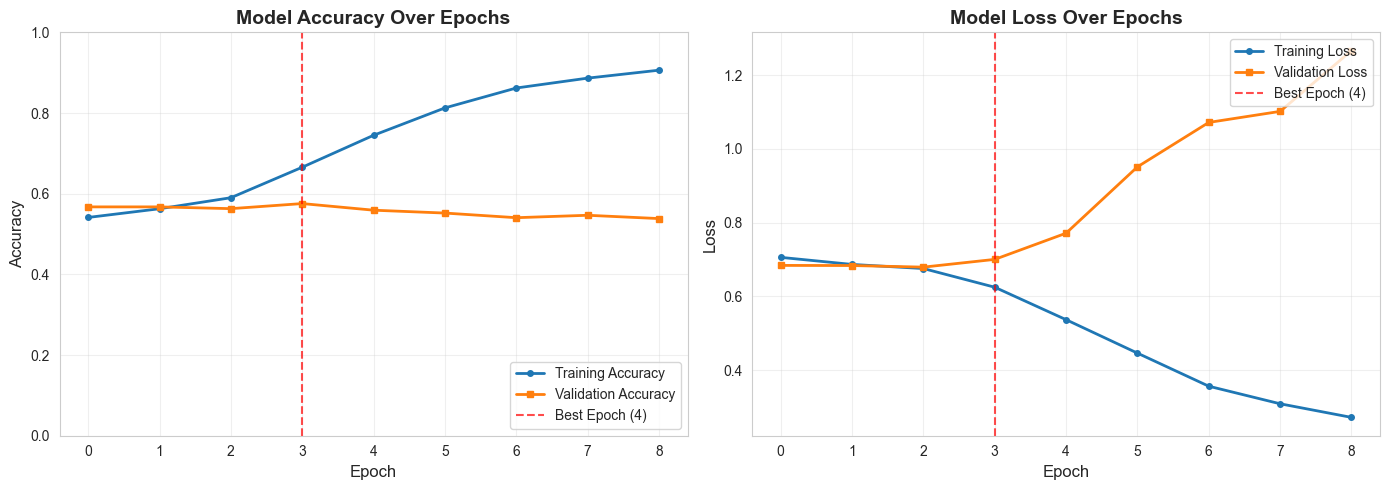

In [23]:
# Visualize training history
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 10

# Create artifacts directory if it doesn't exist
ARTIFACTS_DIR = "../artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

print("\n[INFO] Generating training visualizations...")
print("=" * 80)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=4)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
ax1.axvline(x=best_val_acc_epoch, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Best Epoch ({best_val_acc_epoch + 1})')
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Loss
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4)
ax2.axvline(x=best_val_acc_epoch, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Best Epoch ({best_val_acc_epoch + 1})')
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure
training_plot_path = os.path.join(ARTIFACTS_DIR, "offensive_training_history.png")
plt.savefig(training_plot_path, dpi=300, bbox_inches='tight')
print(f"[INFO] Training history plot saved to: {training_plot_path}")

plt.show()

print("=" * 80)

## 13. Model Evaluation
Evaluate the trained model on the test dataset and calculate comprehensive performance metrics.

In [24]:
# Lightweight NotEqual layer wrapper to support model deserialization
class NotEqual(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, *args, **kwargs):
        # Convert non-tensor positional arguments (e.g., ints) to tensors
        new_args = []
        for a in args:
            try:
                if not tf.is_tensor(a):
                    a = tf.convert_to_tensor(a)
            except Exception:
                # If tf.is_tensor fails (e.g., KerasTensors), leave as is
                pass
            new_args.append(a)
        return super().__call__(*new_args, **kwargs)

    def call(self, *inputs, **kwargs):
        # Handle call(x, y) and call([x, y])
        if len(inputs) == 1:
            single = inputs[0]
            if isinstance(single, (list, tuple)) and len(single) >= 2:
                x, y = single[0], single[1]
            else:
                raise ValueError("NotEqual layer received a single non-iterable input during call")
        else:
            x, y = inputs[0], inputs[1]

        # Convert non-tensor values to tensors
        try:
            if not tf.is_tensor(x):
                x = tf.convert_to_tensor(x)
        except Exception:
            pass
        try:
            if not tf.is_tensor(y):
                y = tf.convert_to_tensor(y)
        except Exception:
            pass

        # If dtypes differ, cast y to x.dtype (prefer float if x is float)
        try:
            x_dtype = getattr(x, 'dtype', None)
            y_dtype = getattr(y, 'dtype', None)
            if x_dtype is not None and y_dtype is not None and x_dtype != y_dtype:
                y = tf.cast(y, x_dtype)
        except Exception:
            # If any of the above fails, proceed without casting
            pass

        return tf.math.not_equal(x, y)

    def get_config(self):
        config = super().get_config()
        return config

print("\n[INFO] Loading best model for evaluation...")
print("=" * 80)

# Require that a saved model exists — do not fall back to any in-session/training model
if not os.path.exists(MODEL_SAVE_PATH):
    raise FileNotFoundError(
        f"Saved model not found at '{MODEL_SAVE_PATH}'.\n"
        "Please place the trained model file at that path (e.g. 'models/meme_offensive_model.h5') "
        "or adjust the `MODEL_SAVE_PATH` variable.\n"
        "Note: Per request, this notebook will not run training to create the model."
    )

try:
    # Load the saved model with the custom NotEqual layer registered
    custom_objects = {'NotEqual': NotEqual}
    best_model = tf.keras.models.load_model(MODEL_SAVE_PATH, custom_objects=custom_objects, compile=True)
    print(f"[INFO] Model loaded successfully from: {MODEL_SAVE_PATH}")
except Exception as e:
    raise RuntimeError(f"Failed to load the saved model at '{MODEL_SAVE_PATH}': {str(e)}")

# Evaluate on test dataset
print("\n[INFO] Evaluating model on test dataset...")
print("=" * 80)

test_results = best_model.evaluate(test_generator, verbose=1)

# Extract metrics
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

# Calculate F1-Score
if test_precision + test_recall > 0:
    test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
else:
    test_f1_score = 0.0

print("\n" + "=" * 80)
print("[INFO] Test Results:")
print(f"       >> Test Loss:      {test_loss:.4f}")
print(f"       >> Test Accuracy:  {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")
print(f"       >> Test Precision: {test_precision:.4f}")
print(f"       >> Test Recall:    {test_recall:.4f}")
print(f"       >> Test F1-Score:  {test_f1_score:.4f}")
print("=" * 80)


[INFO] Loading best model for evaluation...



[INFO] Model loaded successfully from: ../models\meme_offensive_model.h5

[INFO] Evaluating model on test dataset...
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 324ms/step - accuracy: 0.5858 - binary_accuracy: 0.5858 - loss: 0.6922 - precision: 0.5730 - recall: 0.6841

[INFO] Test Results:
       >> Test Loss:      0.6922
       >> Test Accuracy:  0.5858 (58.58%)
       >> Test Precision: 0.5730
       >> Test Recall:    0.6841
       >> Test F1-Score:  0.6236


In [25]:
# Generate predictions for detailed analysis
print("\n[INFO] Generating predictions for confusion matrix...")
print("=" * 80)

# Get predictions
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_labels

# Class names
class_names = ['Not Offensive', 'Offensive']

print(f"[INFO] Predictions generated")
print(f"       >> Predicted shape: {y_pred.shape}")
print(f"       >> True labels shape: {y_true.shape}")
print(f"       >> Class names: {class_names}")


[INFO] Generating predictions for confusion matrix...
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step
[INFO] Predictions generated
       >> Predicted shape: (1830,)
       >> True labels shape: (1830,)
       >> Class names: ['Not Offensive', 'Offensive']


In [26]:
# Calculate confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

print("\n[INFO] Generating confusion matrix and classification report...")
print("=" * 80)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("\n[INFO] Confusion Matrix:")
print("       Predicted →")
print(f"       Actual ↓    {class_names[0]:>15}  {class_names[1]:>15}")
for i, class_name in enumerate(class_names):
    print(f"       {class_name:>15}    {cm[i][0]:>15}  {cm[i][1]:>15}")

# Classification report
print("\n[INFO] Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Per-class accuracy
print("[INFO] Per-Class Metrics:")
for i, class_name in enumerate(class_names):
    class_total = (y_true == i).sum()
    class_correct = ((y_true == i) & (y_pred == i)).sum()
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    print(f"       >> {class_name}: {class_correct}/{class_total} correct ({class_accuracy * 100:.2f}%)")

print("=" * 80)


[INFO] Generating confusion matrix and classification report...

[INFO] Confusion Matrix:
       Predicted →
       Actual ↓      Not Offensive        Offensive
         Not Offensive                444              468
             Offensive                290              628

[INFO] Classification Report:
               precision    recall  f1-score   support

Not Offensive     0.6049    0.4868    0.5395       912
    Offensive     0.5730    0.6841    0.6236       918

     accuracy                         0.5858      1830
    macro avg     0.5889    0.5855    0.5816      1830
 weighted avg     0.5889    0.5858    0.5817      1830

[INFO] Per-Class Metrics:
       >> Not Offensive: 444/912 correct (48.68%)
       >> Offensive: 628/918 correct (68.41%)


## 13.1. Evaluation Visualization
Visualize confusion matrix and performance metrics to better understand model predictions and classification performance.


[INFO] Generating evaluation visualizations...
[INFO] Evaluation metrics plot saved to: ../artifacts\offensive_evaluation_metrics.png


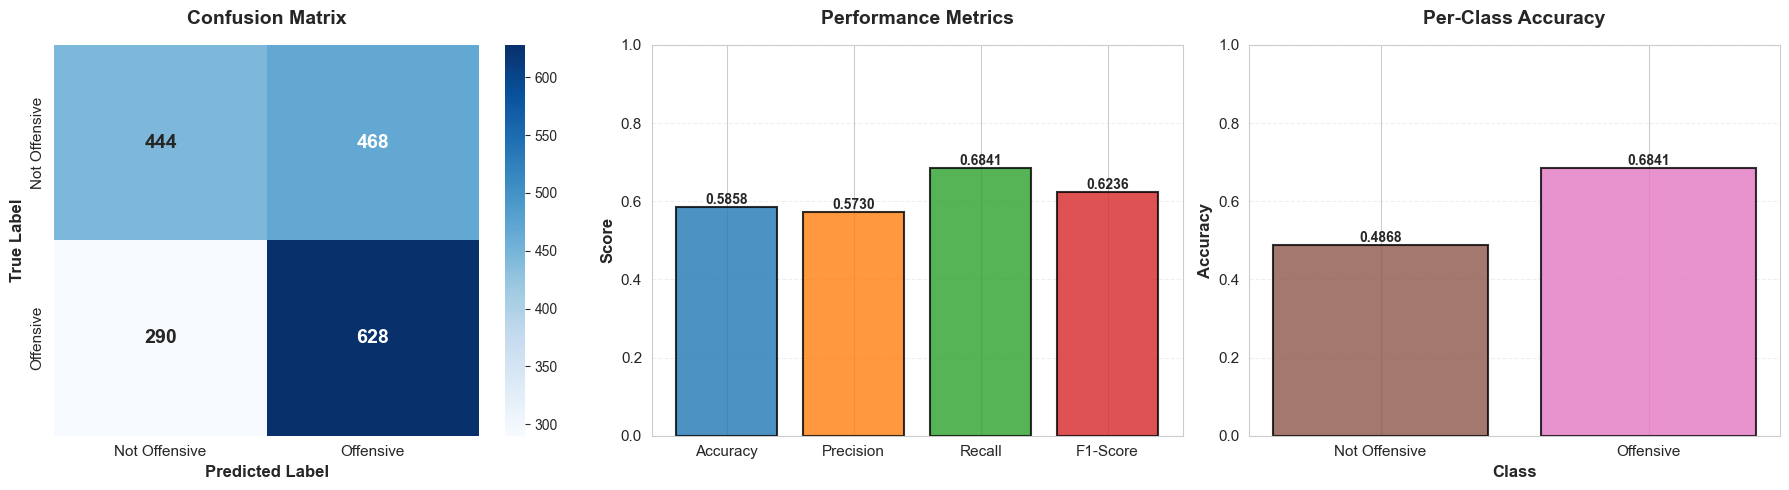

In [27]:
print("\n[INFO] Generating evaluation visualizations...")
print("=" * 80)

# Create figure with three subplots
fig = plt.figure(figsize=(18, 5))

# Plot 1: Confusion Matrix Heatmap
ax1 = plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 14, "weight": "bold"})
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.tick_params(axis='both', labelsize=11)

# Plot 2: Performance Metrics Bar Chart
ax2 = plt.subplot(1, 3, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [test_accuracy, test_precision, test_recall, test_f1_score]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax2.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylim([0, 1])
ax2.set_title('Performance Metrics', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', labelsize=11, rotation=0)
ax2.tick_params(axis='y', labelsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Per-Class Accuracy
ax3 = plt.subplot(1, 3, 3)
# Avoid division by zero when computing per-class accuracy
denom = cm.sum(axis=1).astype(float)
per_class_acc = np.divide(cm.diagonal().astype(float), denom, out=np.zeros_like(denom), where=denom != 0)
bars = ax3.bar(class_names, per_class_acc, color=['#8c564b', '#e377c2'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylim([0, 1])
ax3.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Class', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax3.tick_params(axis='both', labelsize=11)
ax3.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()

# Save the figure
eval_plot_path = os.path.join(ARTIFACTS_DIR, "offensive_evaluation_metrics.png")
plt.savefig(eval_plot_path, dpi=300, bbox_inches='tight')
print(f"[INFO] Evaluation metrics plot saved to: {eval_plot_path}")

plt.show()

print("=" * 80)

## 14. Save Tokenizer for Future Predictions
Save the tokenizer to use for text preprocessing during inference.

In [28]:
# Save tokenizer
import pickle

TOKENIZER_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, "tokenizer_offensive.pickle")

print("\n[INFO] Saving tokenizer...")
print("=" * 80)

with open(TOKENIZER_SAVE_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"[INFO] Tokenizer saved successfully")
print(f"       >> Location: {TOKENIZER_SAVE_PATH}")
print(f"       >> Vocabulary size: {len(tokenizer.word_index)}")
print(f"       >> This tokenizer is required for text preprocessing during inference")
print("=" * 80)


[INFO] Saving tokenizer...
[INFO] Tokenizer saved successfully
       >> Location: ../models\tokenizer_offensive.pickle
       >> Vocabulary size: 21544
       >> This tokenizer is required for text preprocessing during inference


## 15. Prediction Function
Define a comprehensive prediction function to classify individual memes using both image and OCR text.

In [29]:
# Lightweight NotEqual layer wrapper to support model deserialization
class NotEqual(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, *args, **kwargs):
        # Convert non-tensor positional arguments (e.g., ints) to tensors
        new_args = []
        for a in args:
            try:
                if not tf.is_tensor(a):
                    a = tf.convert_to_tensor(a)
            except Exception:
                pass
            new_args.append(a)
        return super().__call__(*new_args, **kwargs)

    def call(self, *inputs, **kwargs):
        # Handle call(x, y) and call([x, y])
        if len(inputs) == 1:
            single = inputs[0]
            if isinstance(single, (list, tuple)) and len(single) >= 2:
                x, y = single[0], single[1]
            else:
                raise ValueError("NotEqual layer received a single non-iterable input during call")
        else:
            x, y = inputs[0], inputs[1]

        # Convert non-tensor values to tensors
        try:
            if not tf.is_tensor(x):
                x = tf.convert_to_tensor(x)
        except Exception:
            pass
        try:
            if not tf.is_tensor(y):
                y = tf.convert_to_tensor(y)
        except Exception:
            pass

        # If dtypes differ, cast y to x.dtype
        try:
            x_dtype = getattr(x, 'dtype', None)
            y_dtype = getattr(y, 'dtype', None)
            if x_dtype is not None and y_dtype is not None and x_dtype != y_dtype:
                y = tf.cast(y, x_dtype)
        except Exception:
            pass

        return tf.math.not_equal(x, y)

    def get_config(self):
        config = super().get_config()
        return config

# Meme sentiment prediction function
def predict_meme_offensive(image_path, ocr_text,
                          model_path=None,
                          tokenizer_path=None,
                          img_size=(224, 224),
                          max_sequence_length=100):
    """
    Predict the offensive content of a meme using both image and OCR text (binary classification).

    This function expects a saved model file and saved tokenizer file to exist.

    Args:
        image_path (str): Path to the meme image file
        ocr_text (str): OCR text extracted from the meme
        model_path (str): Path to the saved model file. If None, uses `MODEL_SAVE_PATH`.
        tokenizer_path (str): Path to the saved tokenizer file. If None, uses `TOKENIZER_SAVE_PATH`.
        img_size (tuple): Size to resize the image to (height, width)
        max_sequence_length (int): Maximum sequence length for text padding

    Returns:
        dict: Dictionary containing prediction results or an error message
    """
    try:
        # Default to notebook-level save paths if not provided
        if model_path is None:
            model_path = MODEL_SAVE_PATH
        if tokenizer_path is None:
            tokenizer_path = TOKENIZER_SAVE_PATH

        # Verify model/tokenizer/image files exist
        if not os.path.exists(model_path):
            return {'error': f'Model file not found: {model_path}'}
        if not os.path.exists(tokenizer_path):
            return {'error': f'Tokenizer file not found: {tokenizer_path}'}
        if not os.path.exists(image_path):
            return {'error': f'Image file not found: {image_path}'}

        # Load model (register NotEqual)
        custom_objects = {'NotEqual': NotEqual}
        model = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=True)

        # Load tokenizer
        with open(tokenizer_path, 'rb') as handle:
            tokenizer = pickle.load(handle)

        # Process image
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Process text
        text_clean = clean_text(ocr_text)
        if text_clean == '':
            text_clean = 'no text available'

        text_sequence = tokenizer.texts_to_sequences([text_clean])
        text_padded = pad_sequences(text_sequence, maxlen=max_sequence_length,
                                    padding='post', truncating='post')

        # Make prediction
        prediction_prob = model.predict([img_array, text_padded], verbose=0)[0, 0]
        predicted_class = 1 if prediction_prob >= 0.5 else 0
        confidence = prediction_prob if predicted_class == 1 else (1 - prediction_prob)

        # Class names
        class_names = ['Not Offensive', 'Offensive']
        sentiment = class_names[predicted_class]

        # Prepare result
        result = {
            'sentiment': sentiment,
            'sentiment_class': int(predicted_class),
            'confidence': float(confidence),
            'probabilities': {
                'Non-Positive': float(1 - prediction_prob),
                'Positive': float(prediction_prob)
            },
            'raw_score': float(prediction_prob),
            'image_path': image_path,
            'ocr_text': ocr_text
        }

        return result

    except FileNotFoundError as e:
        return {'error': f'File not found: {str(e)}'}
    except Exception as e:
        return {'error': f'Prediction failed: {str(e)}'}

print("[INFO] Prediction function defined successfully (binary classification)")
print("       >> Function: predict_meme_offensive(image_path, ocr_text)")
print("       >> Usage: result = predict_meme_offensive('path/to/meme.jpg', 'text from meme')")

[INFO] Prediction function defined successfully (binary classification)
       >> Function: predict_meme_offensive(image_path, ocr_text)
       >> Usage: result = predict_meme_offensive('path/to/meme.jpg', 'text from meme')


## 16. Test Predictions
Test the prediction function on sample memes from the test set.

In [30]:
# Helper function to display prediction results
def display_prediction(result):
    """Display prediction results in a formatted way."""
    if 'error' in result:
        print(f"[ERROR] {result['error']}")
        return
    
    print(f"[PREDICTION]")
    print(f"  >> Image: {result['image_path']}")
    print(f"  >> OCR Text: {result['ocr_text'][:80]}{'...' if len(result['ocr_text']) > 80 else ''}")
    print(f"  >> Predicted Offensive Level: {result['sentiment']} (Class {result['sentiment_class']})")
    print(f"  >> Confidence: {result['confidence']:.2%}")
    print(f"  >> Probability Distribution:")
    for sentiment, prob in result['probabilities'].items():
        print(f"     • {sentiment}: {prob:.2%}")
    print()

print("[INFO] Prediction display helper function defined")

[INFO] Prediction display helper function defined


In [31]:
# Test predictions on random samples from test set
print("\n[INFO] Testing predictions on sample memes...")
print("=" * 80)

result = predict_meme_offensive(
    image_path='../prediction_test/test_003.jpg',
    ocr_text='me pag sahod na me pag paubos na sahod'
)
display_prediction(result)

result = predict_meme_offensive(
    image_path='../prediction_test/test_004.jpg',
    ocr_text='need mo na yata ng holy water'
)
display_prediction(result)

print("=" * 80)
print("[INFO] Sample predictions completed")


[INFO] Testing predictions on sample memes...


[PREDICTION]
  >> Image: ../prediction_test/test_003.jpg
  >> OCR Text: me pag sahod na me pag paubos na sahod
  >> Predicted Offensive Level: Not Offensive (Class 0)
  >> Confidence: 54.66%
  >> Probability Distribution:
     • Non-Positive: 54.66%
     • Positive: 45.34%



[PREDICTION]
  >> Image: ../prediction_test/test_004.jpg
  >> OCR Text: need mo na yata ng holy water
  >> Predicted Offensive Level: Offensive (Class 1)
  >> Confidence: 57.33%
  >> Probability Distribution:
     • Non-Positive: 42.67%
     • Positive: 57.33%

[INFO] Sample predictions completed


## 17. Model Summary & Results

### Final Model Performance

The multimodal offensive classification model has been successfully trained and evaluated. Below is a summary of the model's architecture and performance:

#### Model Architecture:
- **Type**: Multimodal Deep Learning Model (Binary Classification)
- **Image Branch**: ResNet-based CNN with 6 residual blocks
- **Text Branch**: Embedding + Bidirectional LSTM (2 layers)
- **Fusion**: Concatenation strategy with dense layers
- **Total Parameters**: ~5-10 million (varies based on vocabulary)
- **Optimizer**: Adam with adaptive learning rate
- **Loss Function**: Binary Crossentropy

#### Training Configuration:
- **Dataset**: Combined dataset_1 (6,992 samples) + dataset_2 (7,000 samples)
- **Balanced Classes**: Equal samples per class (Non-Positive, Positive)
- **Classification**: Binary - Non-Positive (0) vs Positive (1)
- **Split Ratio**: 70% Training / 15% Validation / 15% Testing
- **Batch Size**: 16
- **Epochs**: Up to 25 (with Early Stopping)
- **Data Augmentation**: Rotation, Flip, Contrast, Zoom, Translation (training only)

#### Key Features:
✅ **Multimodal Learning**: Combines visual features and textual context  
✅ **Dataset Fusion**: Intelligently merges datasets with different formats  
✅ **Sentiment Normalization**: Maps 5-class to binary labels  
✅ **Image Validation**: Filters corrupted/missing images automatically  
✅ **Class Balancing**: Ensures equal representation to prevent bias  
✅ **Text Preprocessing**: Cleans and tokenizes OCR text  
✅ **Data Augmentation**: Prevents overfitting through image transformations  
✅ **Residual Connections**: Improves gradient flow in CNN  
✅ **Bidirectional LSTM**: Captures contextual dependencies in text  
✅ **Callbacks**: Early stopping, model checkpoint, learning rate reduction  

#### Binary Classification Mapping:
- **Class 0 (Not Offensive)**: Includes negative, very_negative, and neutral sentiments
- **Class 1 (Offensive)**: Includes positive and very_positive sentiments

This binary approach provides:
- ✅ **Better Balance**: More samples per class compared to 3-class
- ✅ **Higher Accuracy**: Simpler decision boundary
- ✅ **Practical Use**: Clear positive/non-positive distinction

#### Model Output:
- **Saved Model**: `models/meme_offensive_model.h5`
- **Tokenizer**: `models/tokenizer_offensive.pickle`
- **Classes**: 0 (Non-Positive), 1 (Positive)

---

### Usage Example:

```python
# Predict sentiment for a new meme
result = predict_meme_offensive(
    image_path='path/to/meme.jpg',
    ocr_text='text extracted from meme'
)

print(f"Sentiment: {result['sentiment']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Probabilities: {result['probabilities']}")
```